In [2]:
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import confint_proportions_2indep

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('ggplot')
from matplotlib.pyplot import figure
import seaborn as sns

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

In [3]:
df = pd.read_csv(r'C:\Users\Vlad\Downloads\bank.csv', sep=';')

In [14]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [15]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [1]:
def plot_smart_bar(column, dataframe):
    plt.figure(figsize=(16, 5))

    # 1. График количества (Count Plot)
    plt.subplot(1, 2, 1)
    sns.countplot(data=dataframe, x=column, hue='y', palette='viridis')
    if column == 'age_group':
        plt.title('Количество клиентов по возрасту')
    elif column == 'education':
        plt.title('Количество клиентов по образованию')
    elif column == 'loan':
        plt.title('Количество клиентов с кредитом')
    elif column == 'housing':
        plt.title('Количество клиентов с кредитом на имущество')
    elif column == 'job':
        plt.title('Количество клиентов по профессии')
    else:
        plt.title(f'Количество клиентов по {column}')
    plt.ylabel('Количество')
    if column == 'age_group':
        plt.xlabel('Возраст')
    elif column == 'education':
        plt.xlabel('Образование')
    elif column == 'loan':
        plt.xlabel('Кредит')
    elif column == 'housing':
        plt.xlabel('Кредит на имущество')
    elif column == 'job':
        plt.xlabel('Профессия')
    plt.xticks(rotation=45)

    # 2. График вероятности (Conversion Rate)
    plt.subplot(1, 2, 2)
    temp_df = dataframe.copy()
    temp_df['y_numeric'] = temp_df['y'].map({'yes': 1, 'no': 0})
    
    sns.barplot(data=temp_df, x=column, y='y_numeric', palette='magma', errorbar=None)
    if column == 'age_group':
        plt.title('% успеха (конверсия) по возрасту')
    elif column == 'education':
        plt.title('% успеха (конверсия) по образованию')
    elif column == 'loan':
        plt.title('% успеха (конверсия) по кредиту')
    elif column == 'housing':
        plt.title('% успеха (конверсия) по кредиту на имущество')
    elif column == 'job':
        plt.title('% успеха (конверсия) по профессии')
    else:
        plt.title(f'% успеха (конверсия) по {column}')
    plt.ylabel('Conversion Rate')
    plt.xticks(rotation=45)

    plt.tight_layout()
    if column == 'age_group':
        plt.xlabel('Возраст')
    elif column == 'education':
        plt.xlabel('Образование')
    elif column == 'loan':
        plt.xlabel('Кредит')
    elif column == 'housing':
        plt.xlabel('Кредит на имущество')
    elif column == 'job':
        plt.xlabel('Профессия')
    plt.savefig(f'{column}.png')
    plt.show()

In [1]:
#Тест Хи-квадрат и построение тепловой карты
def chi2_test(column, target_column, df):
    contingency_table = pd.crosstab(df[column], df[target_column])
    chi2, p_val, dof, expected = stats.chi2_contingency(contingency_table)

    print(f"Chi-square p-value: {p_val}")
    if p_val < 0.05:
        print("Есть зависимость")
    else:
        print("Переменные независимы")

    plt.figure(figsize=(8, 5))
    sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(f'Тепловая карта: {column} vs {target_column}')
    plt.ylabel(f'{column}')
    plt.savefig(f'heat_map_{column}.png')
    plt.show()

In [9]:
def cramers_v(column, target_column, dataframe):
    # 1. Строим таблицу сопряженности
    conf_matrix = pd.crosstab(dataframe[column], dataframe[target_column])
    
    # 2. Считаем Хи-квадрат
    chi2 = chi2_contingency(conf_matrix)[0]
    
    # 3. Параметры расчета
    n = conf_matrix.sum().sum() # Общее кол-во наблюдений
    phi2 = chi2 / n
    r, k = conf_matrix.shape
    
    # Формула V Крамера
    # Результат всегда от 0 (нет связи) до 1 (полная зависимость)
    result = np.sqrt(phi2 / min(k - 1, r - 1))
    return result

C:\Users\Vlad\AppData\Local\Temp\ipykernel_13124\2282840661.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='campaign_bins', y='y_numeric', palette='magma', errorbar=None)


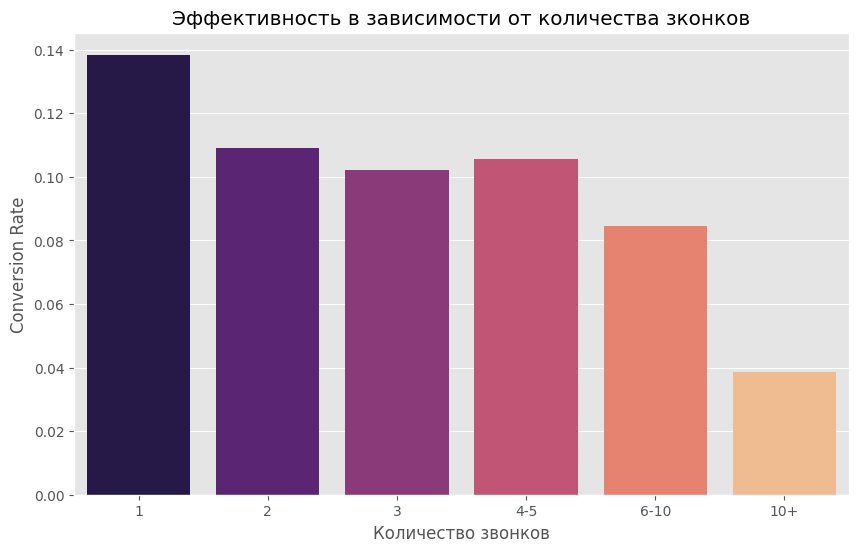

Конверсия при прошлом успехе: 64.34%
Множитель вероятности (Lift): 4.7x


In [6]:
#разделям звонки на бины
bins = [0, 1, 2, 3, 5, 10, 100]
df['y_numeric'] = df['y'].map({'yes': 1, 'no': 0})
labels = ['1', '2', '3', '4-5', '6-10', '10+']
df['campaign_bins'] = pd.cut(df['campaign'], bins=bins, labels=labels)

# Строим график
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='campaign_bins', y='y_numeric', palette='magma', errorbar=None)
plt.title('Эффективность в зависимости от количества зконков')
plt.ylabel('Conversion Rate')
plt.xlabel('Количество звонков')
plt.savefig('calls.png', dpi=300, bbox_inches='tight')
plt.show()


poutcome_stats = df.groupby('poutcome')['y_numeric'].agg(['mean', 'count']).reset_index()
poutcome_stats.columns = ['Outcome', 'Conversion_Rate', 'Total_Calls']

# Считаем Lift для успеха (во сколько раз клиенты, оформившие вклад до этого, чаще оформлят вклад еще раз, чем люди, делающие это впервые)
success_cr = poutcome_stats.loc[poutcome_stats['Outcome'] == 'success', 'Conversion_Rate'].values[0]
others_cr = poutcome_stats.loc[poutcome_stats['Outcome'] != 'success', 'Conversion_Rate'].mean()
lift_poutcome = (success_cr / others_cr)

print(f"Конверсия при прошлом успехе: {success_cr:.2%}")
print(f"Множитель вероятности (Lift): {lift_poutcome:.1f}x")


Chi-square p-value: 2.1005245850379305e-19
Есть зависимость


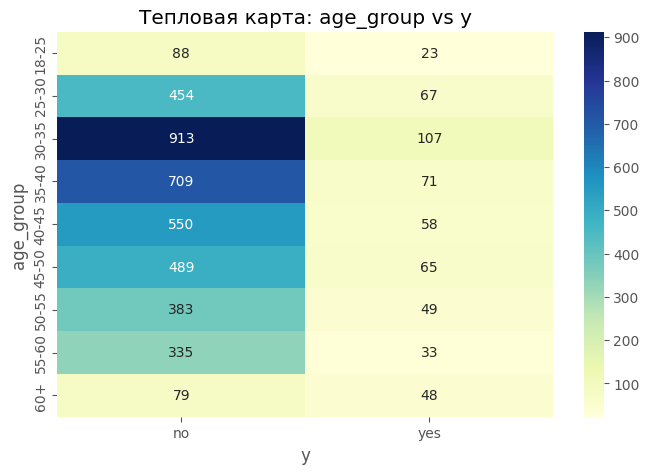

Сила связи для 'age': 0.2057


C:\Users\Vlad\AppData\Local\Temp\ipykernel_13124\1175710182.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=temp_df, x=column, y='y_numeric', palette='magma', errorbar=None)


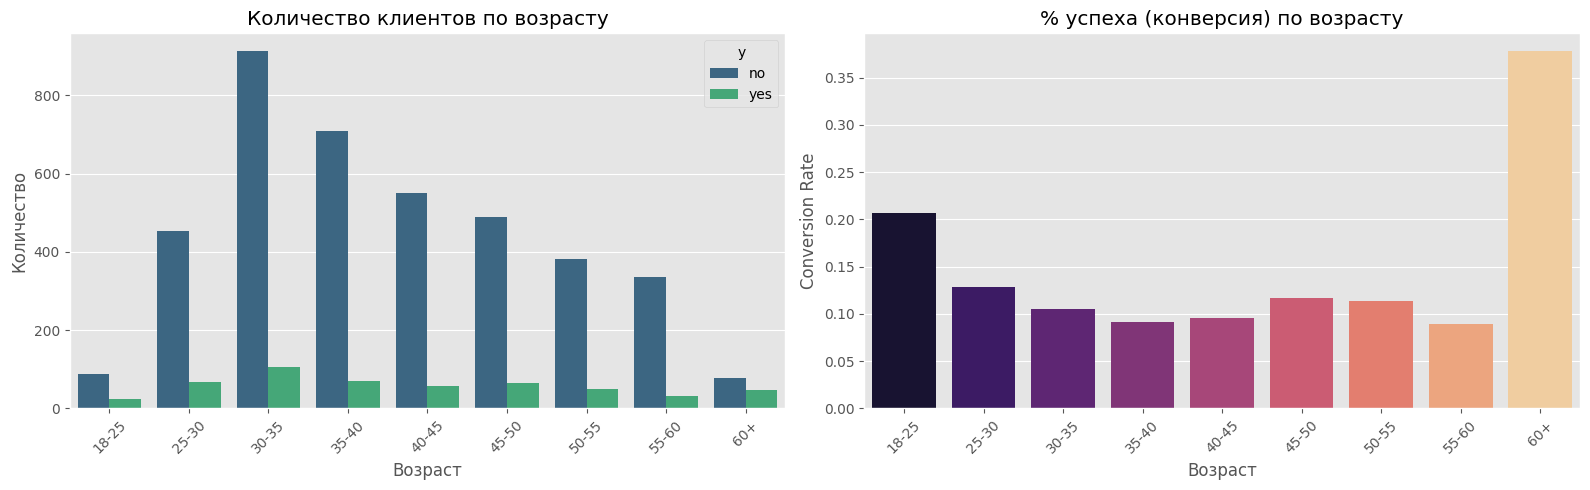

In [12]:
#делим людей по возрастным группам
bins = [18, 25, 30, 35, 40, 45, 50, 55, 60, 90]

labels = ['18-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55', '55-60', '60+']

df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)

chi2_test('age_group', 'y', df)

print(f"Сила связи для 'age': {cramers_v('age', 'y', df):.4f}")

plot_smart_bar('age_group', df)

Chi-square p-value: 0.0006066491191078123
Есть зависимость


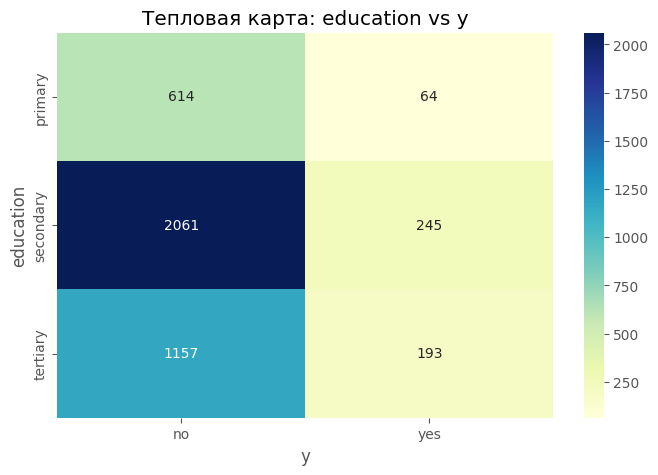

C:\Users\Vlad\AppData\Local\Temp\ipykernel_13124\1175710182.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=temp_df, x=column, y='y_numeric', palette='magma', errorbar=None)


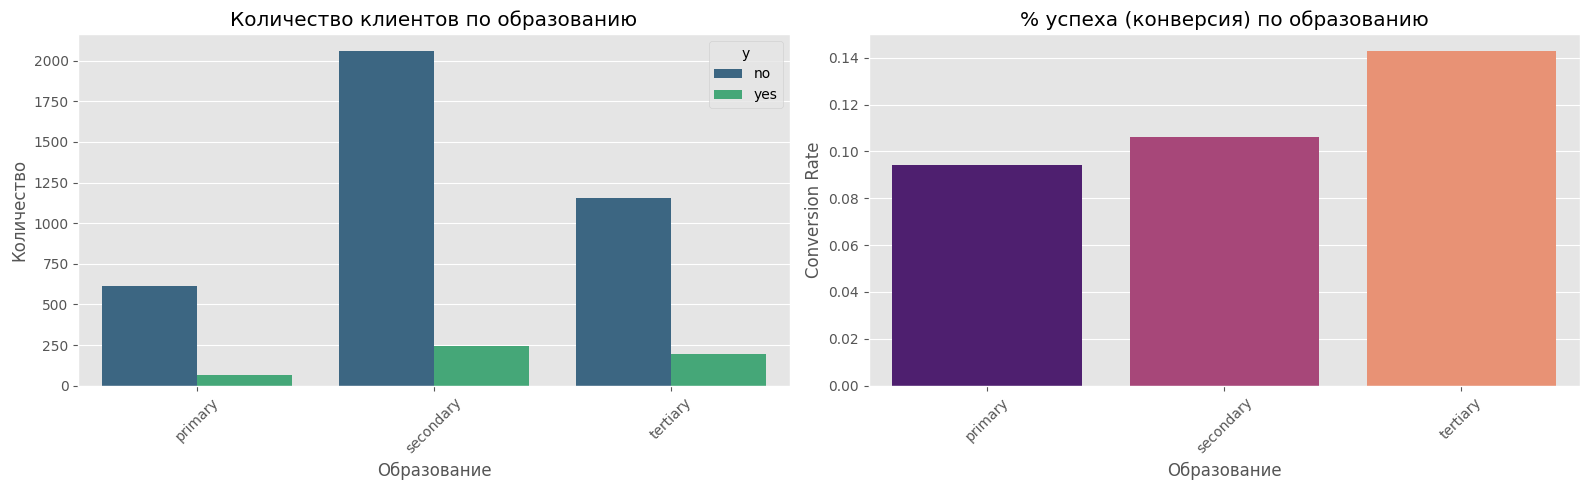

Конверсия (Высшее): 14.30%
Конверсия (Остальные): 10.36%
---
Результат: Высшее образование увеличивает шансы на депозит на 38.1%


<Figure size 800x600 with 0 Axes>

In [13]:
#не будем учитывать клиентов, у которых в образовании unknown
df_clean = df[df['education'] != 'unknown']
chi2_test('education', 'y', df_clean)

plot_smart_bar('education', df_clean)

df['y_numeric'] = df['y'].map({'yes': 1, 'no': 0})

#насколько клиенты с высшим образованием чаще оформляют вклад, чем клиенты без высшего
df_filtered = df[df['education'] != 'unknown'].copy()
df_filtered['edu_group'] = df_filtered['education'].apply(
    lambda x: 'Higher (Tertiary)' if x == 'tertiary' else 'Others (Primary/Secondary)'
)
report = df_filtered.groupby('edu_group')['y_numeric'].agg(['mean', 'count', 'sum']).reset_index()
report.columns = ['Group', 'Conversion_Rate', 'Total_Clients', 'Successes']

#расчет разницы (Lift)
cr_higher = report.loc[report['Group'] == 'Higher (Tertiary)', 'Conversion_Rate'].values[0]
cr_others = report.loc[report['Group'] == 'Others (Primary/Secondary)', 'Conversion_Rate'].values[0]

lift = (cr_higher - cr_others) / cr_others * 100

print(f"Конверсия (Высшее): {cr_higher:.2%}")
print(f"Конверсия (Остальные): {cr_others:.2%}")
print(f"---")
print(f"Результат: Высшее образование увеличивает шансы на депозит на {lift:.1f}%")

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")


Chi-square p-value: 2.9148288298428256e-06
Есть зависимость


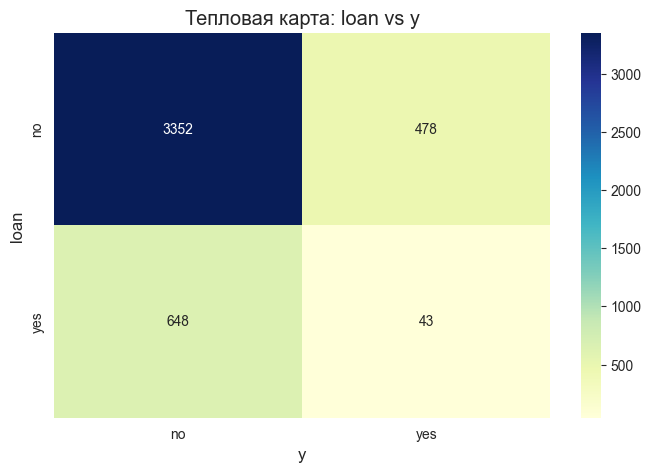

Сила связи для 'loan': 0.0696


C:\Users\Vlad\AppData\Local\Temp\ipykernel_13124\1175710182.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=temp_df, x=column, y='y_numeric', palette='magma', errorbar=None)


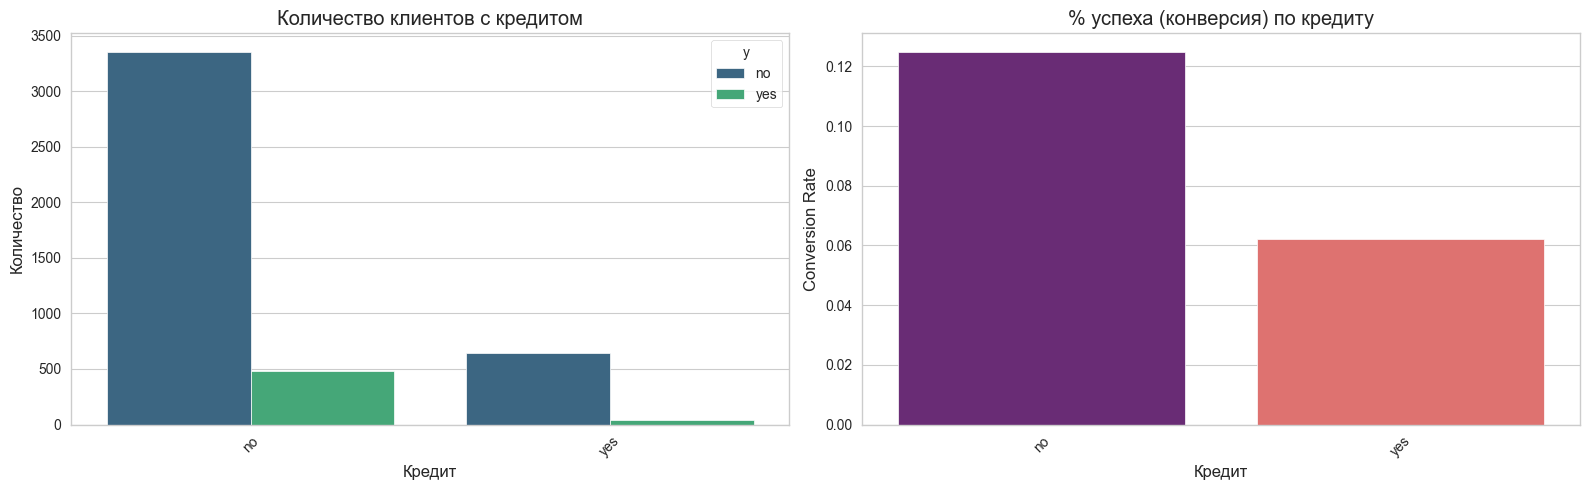

In [15]:
chi2_test('loan', 'y', df)

print(f"Сила связи для 'loan': {cramers_v('loan', 'y', df):.4f}")

plot_smart_bar('loan', df)

Chi-square p-value: 2.7146998959323014e-12
Есть зависимость


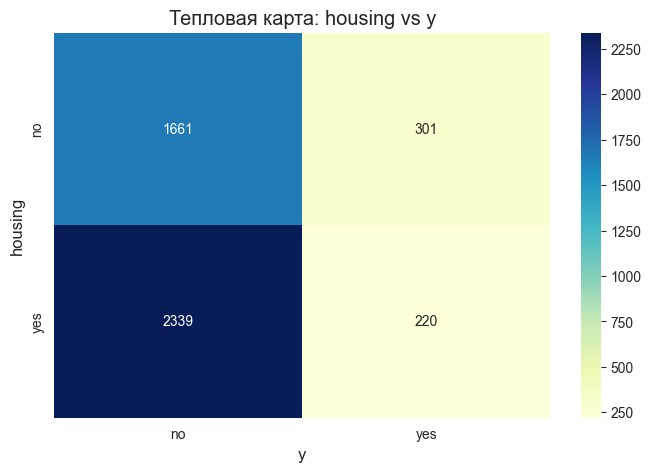

Сила связи для 'housing': 0.1040


C:\Users\Vlad\AppData\Local\Temp\ipykernel_13124\1175710182.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=temp_df, x=column, y='y_numeric', palette='magma', errorbar=None)


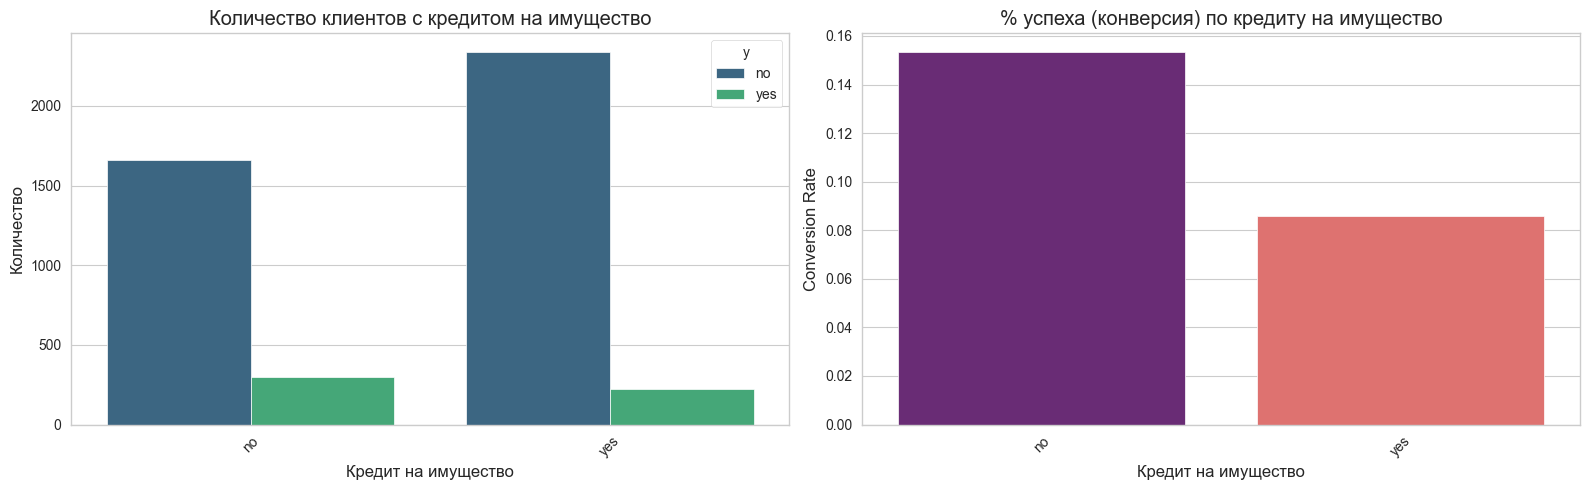

In [16]:
chi2_test('housing', 'y', df)

print(f"Сила связи для 'housing': {cramers_v('housing', 'y', df):.4f}")

plot_smart_bar('housing', df)

Chi-square p-value: 1.901391096662705e-10
Есть зависимость между профессией и подпиской на депозит.
Сила связи для 'job': 0.1235


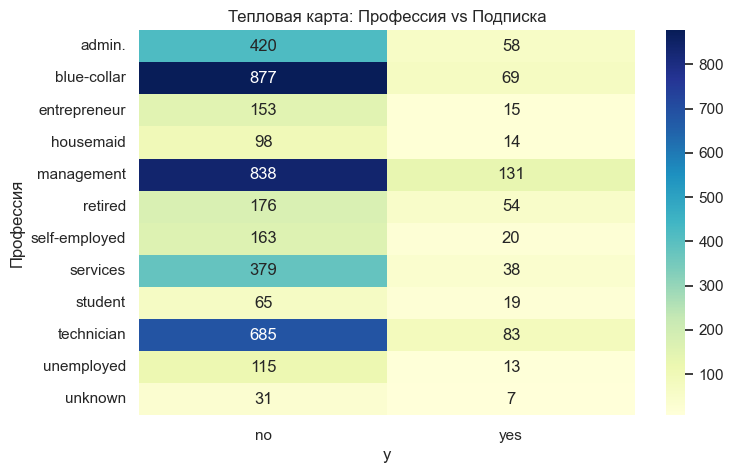

C:\Users\Vlad\AppData\Local\Temp\ipykernel_7792\2201348259.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=temp_df, x=column, y='y_numeric', palette='magma', errorbar=None)


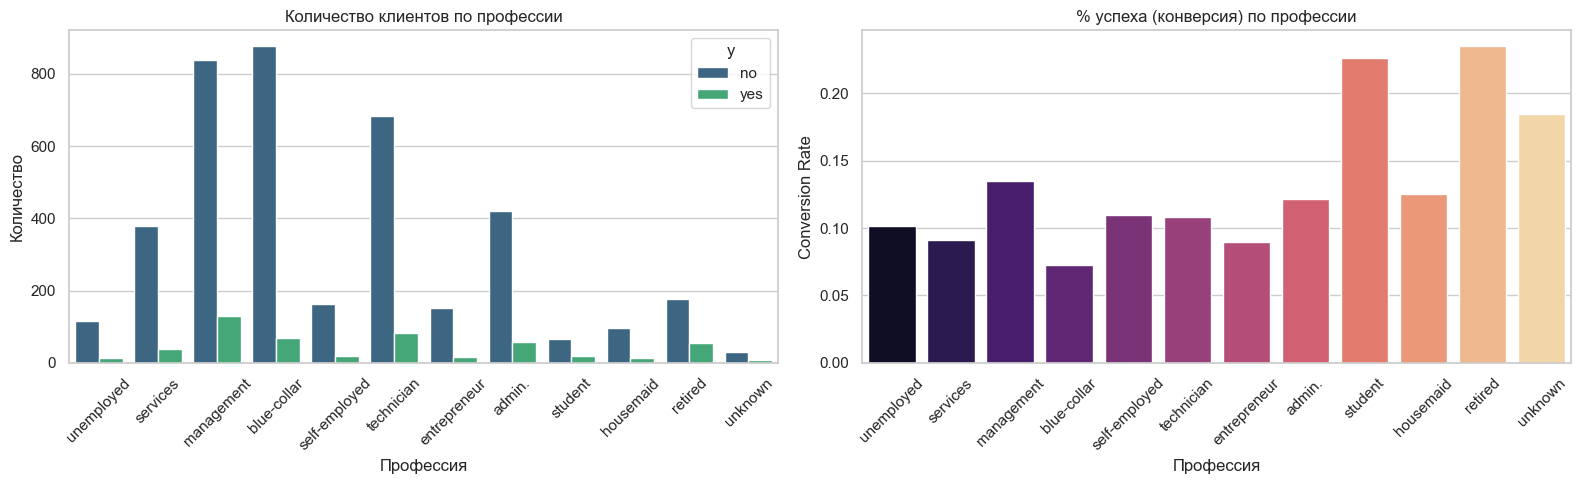

In [69]:
#не будем учитывать клиентов, у которых в профессии unknown
df_clean = df[df['job'] != 'unknown']
chi2_test('job', 'y', df_clean)

print(f"Сила связи для 'job': {cramers_v('job', 'y', df):.4f}")

plot_smart_bar('job', df)